### 构造`n24news`多模态数据集的数据类

In [1]:
from dataclasses import dataclass
import pandas as pd
import torch
import json
import random
from PIL import Image
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Dict, Any, Tuple
from transformers import AutoProcessor
from torch import Tensor
from dataclasses import dataclass

In [3]:
with open('/d/lsy/shared_data/liuhaotian/LLaVA-CC3M-Pretrain-595K/chat.json') as f:
    data = json.loads(f.read())
prompts = [i['conversations'][0]['value'] for i in data]
prompts = set(prompts)
print(len(prompts))
print(prompts)

22
{'Provide a brief description of the given image.\n<image>', '<image>\nOffer a succinct explanation of the picture presented.', 'Create a compact narrative representing the image presented.\n<image>', 'Describe the image concisely.\n<image>', '<image>\nRender a clear and concise summary of the photo.', 'Offer a succinct explanation of the picture presented.\n<image>', '<image>\nGive a short and clear explanation of the subsequent image.', 'Relay a brief, clear account of the picture shown.\n<image>', '<image>\nDescribe the image concisely.', '<image>\nCreate a compact narrative representing the image presented.', "Present a compact description of the photo's key features.\n<image>", '<image>\nWrite a terse but informative summary of the picture.', '<image>\nShare a concise interpretation of the image provided.', 'Summarize the visual content of the image.\n<image>', '<image>\nRelay a brief, clear account of the picture shown.', 'Write a terse but informative summary of the picture.\

In [2]:
human_question_list = [
    'Provide a brief description of the given image.\n<image>',
    '<image>\nOffer a succinct explanation of the picture presented.',
    'Create a compact narrative representing the image presented.\n<image>',
    'Describe the image concisely.\n<image>', '<image>\nRender a clear and concise summary of the photo.',
    'Offer a succinct explanation of the picture presented.\n<image>',
    '<image>\nGive a short and clear explanation of the subsequent image.',
    'Relay a brief, clear account of the picture shown.\n<image>',
    '<image>\nDescribe the image concisely.',
    '<image>\nCreate a compact narrative representing the image presented.',
    "Present a compact description of the photo's key features.\n<image>",
    '<image>\nWrite a terse but informative summary of the picture.',
    '<image>\nShare a concise interpretation of the image provided.',
    'Summarize the visual content of the image.\n<image>',
    '<image>\nRelay a brief, clear account of the picture shown.',
    'Write a terse but informative summary of the picture.\n<image>',
    'Render a clear and concise summary of the photo.\n<image>',
    '<image>\nSummarize the visual content of the image.',
    "<image>\nPresent a compact description of the photo's key features.",
    'Share a concise interpretation of the image provided.\n<image>',
    'Give a short and clear explanation of the subsequent image.\n<image>',
    '<image>\nProvide a brief description of the given image.'
]

In [3]:
dataset_dir = "/d/lsy/shared_data/N24News"
text_file_path = Path(dataset_dir).joinpath("news").joinpath("nytimes.json")
conversation_file_path = Path(dataset_dir).joinpath("news").joinpath("conversation_nytimes.json")
# 读取原始 JSON 文件
with open(text_file_path, 'r', encoding='utf-8') as f:
    text_file = json.load(f)

# 从原始json_item构造符合conversation格式的新item
conversation_list = []
for item in text_file:
    random_question = random.choice(human_question_list)
    conversation_item = {
        "section": item['section'],
        "image": item['image_id'] + '.jpg',
        "conversations": [
            {
                "from": "human",
                "value": random_question
            },
            {
                "from": "gpt",
                "value": item['caption']
            }
        ]
    }
    conversation_list.append(conversation_item)

with open(conversation_file_path, 'w', encoding='utf-8') as wf:
    json.dump(conversation_list, wf, ensure_ascii=False, indent=2)

print(f"新的 JSON 文件已保存到：{conversation_file_path}")


新的 JSON 文件已保存到：/d/lsy/shared_data/N24News/news/conversation_nytimes.json


In [4]:
class N24News_LlavaDataset(Dataset):
    # 构造函数
    def __init__(self, dataset_dir:str) -> None:
        super().__init__()
        self.text_data, self.image_dir = self.build_dataset(dataset_dir=dataset_dir)
    
    def build_dataset(self, dataset_dir:str) -> tuple[List[Dict[str, Any]], Path]:
        dataset_dir = Path(dataset_dir)
        text_file_path = dataset_dir.joinpath("news").joinpath("conversation_nytimes.json")
        image_dir = dataset_dir.joinpath("imgs")
        text_data = pd.read_json(path_or_buf=text_file_path).to_dict(orient="records")
        return text_data, image_dir

    def __len__(self) -> int:
        return len(self.text_data)

    def __getitem__(self, index) -> tuple[str, Path]:
        cur_data = self.text_data[index]
        human_input = cur_data['conversations'][0]['value']
        gpt_output = cur_data['conversations'][1]['value']
        image_path = self.image_dir.joinpath(cur_data.get('image'))
        return (human_input, gpt_output, image_path)

In [9]:
n24news_llava_dataset = N24News_LlavaDataset(dataset_dir=dataset_dir)
len(n24news_llava_dataset)

61235

In [10]:
n24news_llava_dataset[12889]

('Create a compact narrative representing the image presented.\n<image>',
 'Using vintage gear, Dylan Wissing wants to duplicate everything about how Clyde Stubblefield played the James Brown track "Funky Drummer."',
 PosixPath('/d/lsy/shared_data/N24News/imgs/e23c5356-6f68-58ca-ac7b-b69fd3ef0639.jpg'))

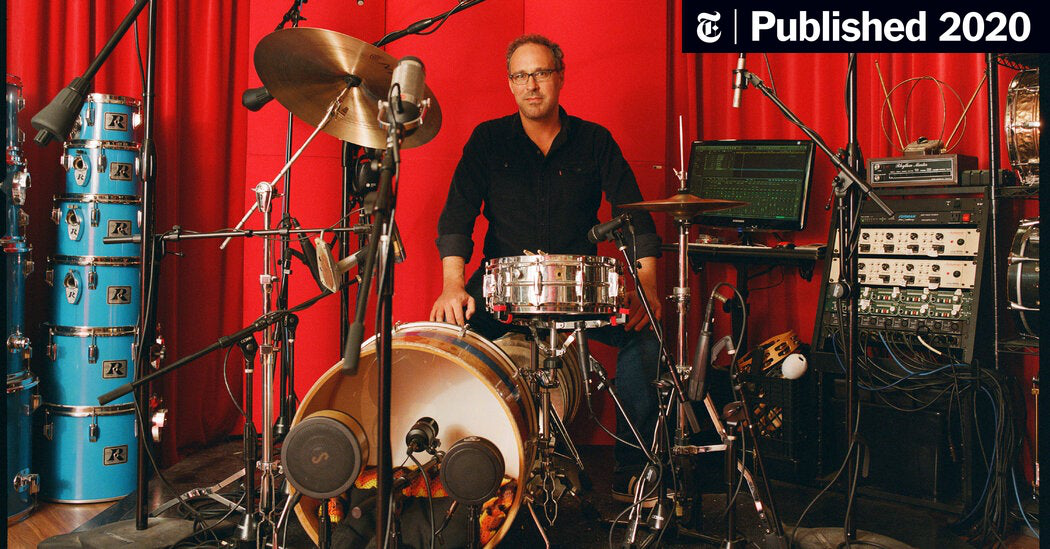

In [8]:
Image.open(fp = n24news_llava_dataset[12889][2])